In [1]:
import matplotlib.pyplot as plt
import pandas as pd

def loss_plot(train_loss,val_loss,epoch_axis,savepath):
    plt.plot(train_loss,label='train_loss')
    plt.plot(val_loss,label='val_loss')
    plt.xticks(epoch_axis)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(savepath)
    plt.close()
    
def extract_evaluation(result_csv):
    df = pd.read_csv(result_csv)
    train_loss = df['train_loss'].values
    val_loss = df['val_loss'].values
    epoch_axis = df['epoch'].values
    return train_loss,val_loss,epoch_axis

extract_evaluation('../../Output/SwingTransformer/Cluster/Test_02/train_metrics.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../../Output/SwingTransformer/Cluster/Test_02/train_metrics.csv'

In [3]:
train_loss = pd.read_csv('../../Output/SwingTransformer/Cluster/Test_02/01train_metrics.csv')

train_loss = train_loss.iloc[0::2]

val_loss = pd.read_csv('../../Output/SwingTransformer/Cluster/Test_02/01vali_metrics.csv')

val_loss = val_loss.iloc[0::2]
val_loss

,epoch,class_0_tp,class_0_fp,class_0_tn,class_0_fn,class_1_tp,class_1_fp,class_1_tn,class_1_fn,class_2_tp,...,class_3_tn,class_3_fn,class_4_tp,class_4_fp,class_4_tn,class_4_fn,accuracy,roc_auc,f1_score,loss
0,2,40.0,10.0,0.0,0.0,0.0,0.0,40.0,10.0,0.0,...,50.0,0.0,0.0,0.0,50.0,0.0,0.8,NaN,0.4444444444444445,0.5398815035820007
2,3,7.0,2.0,8.0,33.0,8.0,33.0,7.0,2.0,0.0,...,50.0,0.0,0.0,0.0,50.0,0.0,0.3,NaN,0.2997198879551821,0.781902221441269
4,4,40.0,10.0,0.0,0.0,0.0,0.0,40.0,10.0,0.0,...,50.0,0.0,0.0,0.0,50.0,0.0,0.8,NaN,0.4444444444444445,0.5864312291145325
6,5,0.0,0.0,10.0,40.0,10.0,40.0,0.0,0.0,0.0,...,50.0,0.0,0.0,0.0,50.0,0.0,0.2,NaN,0.16666666666666669,0.7995415139198303
8,6,0.0,0.0,10.0,40.0,10.0,40.0,0.0,0.0,0.0,...,50.0,0.0,0.0,0.0,50.0,0.0,0.2,NaN,0.16666666666666669,0.9217954677343368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,117,20.0,6.0,4.0,20.0,4.0,20.0,20.0,6.0,0.0,...,50.0,0.0,0.0,0.0,50.0,0.0,0.48,NaN,0.4206773618538324,0.8311685823439621
232,118,34.0,7.0,3.0,6.0,3.0,6.0,34.0,7.0,0.0,...,50.0,0.0,0.0,0.0,50.0,0.0,0.74,NaN,0.5776478232618583,0.6527397327136714
234,119,30.0,8.0,2.0,10.0,2.0,10.0,30.0,8.0,0.0,...,50.0,0.0,0.0,0.0,50.0,0.0,0.64,NaN,0.47552447552447547,0.7828160124714486
236,120,31.0,4.0,6.0,9.0,6.0,9.0,31.0,4.0,0.0,...,50.0,0.0,0.0,0.0,50.0,0.0,0.74,NaN,0.6533333333333333,0.7436366432445357


In [4]:
train_loss = train_loss['loss'].values.tolist()
val_loss = val_loss['loss'].values.tolist()

train_loss = [round(float(i),3) for i in train_loss]
val_loss = [round(float(i),3) for i in val_loss]

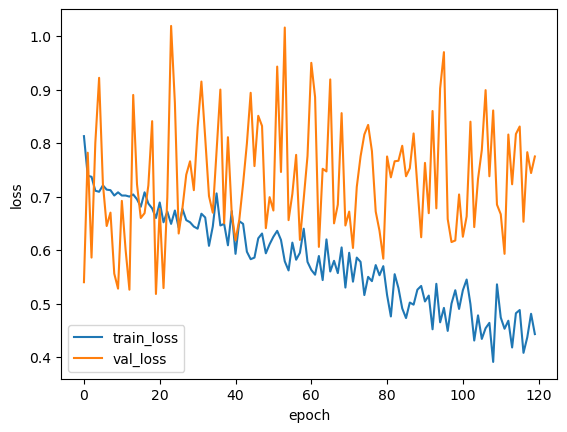

In [6]:
epoch_axis = range(100)
plt.plot(train_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')

#plt.xticks(epoch_axis)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [88]:
train_rates = pd.read_csv('../../Output/SwingTransformer/Cluster/Test_02/01train_Four_rate.csv')

train_acc = train_rates.iloc[1::6]['accuracy']

val_rates = pd.read_csv('../../Output/SwingTransformer/Cluster/Test_02/01vali_four rates.csv')

val_acc = val_rates.iloc[1::6]['accuracy']

In [73]:
train_rates.iloc[1::6]['precision']

1      0.3157894736842105
7                  0.4375
13     0.5526315789473685
19                    0.5
25     0.4492753623188406
              ...        
691    0.7108433734939759
697    0.8188976377952756
703    0.7666666666666667
709    0.7685185185185185
715    0.7619047619047619
Name: precision, Length: 120, dtype: object

In [89]:
train_precision = train_rates.iloc[1::6]['precision'].values.tolist()
train_recall = train_rates.iloc[1::6]['recall'].values.tolist()

train_precision = [round(float(i),3) for i in train_precision]
train_recall = [round(float(i),3) for i in train_recall]


val_precision = val_rates.iloc[1::6]['precision'].values.tolist()
val_recall = val_rates.iloc[1::6]['recall'].values.tolist()

val_precision = [round(float(i),3) for i in val_precision]
val_recall = [round(float(i),3) for i in val_recall]


In [85]:
train_recall

[0.22,
 0.368,
 0.612,
 0.49,
 0.344,
 0.61,
 0.527,
 0.688,
 0.718,
 0.653,
 0.535,
 0.651,
 0.615,
 0.713,
 0.505,
 0.566,
 0.541,
 0.92,
 0.57,
 0.747,
 0.337,
 0.494,
 0.663,
 0.726,
 0.588,
 0.819,
 0.745,
 0.608,
 0.739,
 0.689,
 0.564,
 0.614,
 0.573,
 0.789,
 0.596,
 0.574,
 0.698,
 0.691,
 0.596,
 0.667,
 0.649,
 0.657,
 0.553,
 0.74,
 0.774,
 0.644,
 0.554,
 0.506,
 0.769,
 0.629,
 0.638,
 0.739,
 0.66,
 0.75,
 0.804,
 0.673,
 0.602,
 0.578,
 0.564,
 0.702,
 0.762,
 0.726,
 0.729,
 0.663,
 0.693,
 0.762,
 0.698,
 0.667,
 0.673,
 0.724,
 0.75,
 0.802,
 0.591,
 0.798,
 0.765,
 0.694,
 0.8,
 0.677,
 0.752,
 0.75,
 0.755,
 0.781,
 0.707,
 0.78,
 0.833,
 0.765,
 0.769,
 0.778,
 0.779,
 0.74,
 0.765,
 0.765,
 0.824,
 0.813,
 0.753,
 0.818,
 0.89,
 0.806,
 0.767,
 0.796,
 0.819,
 0.735,
 0.733,
 0.827,
 0.707,
 0.776,
 0.823,
 0.844,
 0.825,
 0.758,
 0.781,
 0.785,
 0.827,
 0.864,
 0.76,
 0.678,
 0.92,
 0.86,
 0.783,
 0.873]

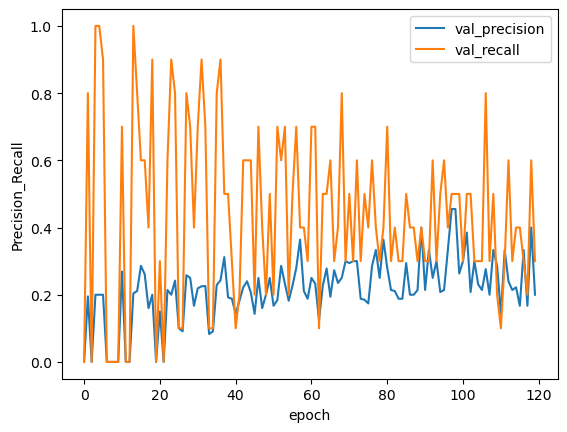

In [93]:
epoch_axis = range(120)
plt.plot(val_precision,label='val_precision')
plt.plot(val_recall,label='val_recall')

#plt.xticks(epoch_axis)
plt.xlabel('epoch')
plt.ylabel('Precision_Recall')
plt.legend()

In [18]:
train_loss

0       0.494949494949495
6      0.4696969696969697
12     0.5404040404040404
18     0.5151515151515151
24       0.51010101010101
              ...        
690    0.7373737373737373
696    0.8383838383838383
702    0.7828282828282829
708    0.7575757575757576
714    0.7777777777777778
Name: accuracy, Length: 120, dtype: object